In [180]:
import json
from tld import get_fld
import csv
import os.path
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import re
from tld.exceptions import TldDomainNotFound, TldBadUrl
from datetime import datetime,timedelta
from itertools import chain
import pandas as pd

In [181]:
#initialize all global analysis variables
page_load_time_desktop=[]
page_load_time_mobile=[]
num_requests_desktop=[]
num_requests_mobile=[]
num_third_parties_desktop=[]
num_third_parties_mobile=[]
num_trackers_domain_desktop=[]
num_trackers_domain_mobile=[]
num_trackers_ent_desktop=[]
num_trackers_ent_mobile=[]


third_parties_desktop_list=[]
third_parties_mobile_list=[]
tracker_domain_desktop_list=[]
tracker_domain_mobile_list=[]
tracker_ent_desktop_list=[]
tracker_ent_mobile_list=[]

analysis_websites_desktop=[]
analysis_tranco_desktop=[]

analysis_websites_mobile=[]
analysis_tranco_mobile=[]

domain_not_found=[]

max_cookie_req_desk=[]
max_cookie_website_desk=[]
max_cookie_num_desk=[]
max_first_party_desk=[]

max_cookie_req_mob=[]
max_cookie_website_mob=[]
max_cookie_num_mob=[]
max_first_party_mob=[]

max_cookie_num_desk.append(0)
max_cookie_req_desk.append("NA")
max_cookie_website_desk.append("NA")
max_first_party_desk.append(True)
               

max_cookie_num_mob.append(0)
max_cookie_req_mob.append("NA")
max_cookie_website_mob.append("NA")
max_first_party_mob.append(True)


delta = timedelta(days=0,seconds=0,microseconds=0,milliseconds=0,minutes=0,hours=0,weeks=0)
top_cookies_desktop=["site1","site2","site3"]
top_cookies_mobile=["site1","site2","site3"]

top_lifespan_desktop=[delta,delta,delta]
top_lifespan_mobile=[delta,delta,delta]

unhandled_time_formats=[]


redirect_desktop=[]
redirect_mobile=[]

not_redirection=[]

not_valid_domain=[]
               



In [182]:
#load the disconnect blocklist as top level domains
f = open('services.json') 
disconnect = json.load(f) 
disconnect=disconnect['categories']
disconnect_blocklist=[]
for entry in disconnect:
    domain_list=disconnect[entry]
    for item in domain_list:
        keys=item.keys()
        for key, value in item.items():
            for inner_key,inner_value in value.items():
                for element in inner_value:
                    if len(element)>1:
                        disconnect_blocklist.append(element)




In [183]:
f = open('domain_map.json') 
domain_map = json.load(f) 

In [184]:
#function to take a website visit dictionary and return the page load time
def get_page_load_time(website):
    start_time=website['pageload_start_ts']
    end_time=website['pageload_end_ts']
    return end_time-start_time

In [185]:
#function to take a website visit dictionary and return the number of requests
def get_num_requests(website):
    return len(website['requests'])


In [186]:
#function to take a website visit dictionary and return the third parties of all requests
def get_third_parties(website):
    third_party_domains=set()
    first_domain=website['domain']
    for req in website['requests']:
        try:
            req_domain=get_fld(req['request_url'])
        except TldDomainNotFound as e:
                domain_not_found.append(req['request_url']) #these domains are IP addresses only and not a hostname
                #printed at the end of the notebook

        if (req_domain!=first_domain):
             third_party_domains.add(req_domain)
    third_party_domains=list(third_party_domains)
    return third_party_domains

In [187]:
#takes a list of third paries and returns a list of those that are trackers
def get_tracker_domains(third_party_list):
    tracker_domains=set()
    for item in third_party_list:
        if item in disconnect_blocklist:
            tracker_domains.add(item)
    tracker_domains_to_list=(list)(tracker_domains)
    return tracker_domains_to_list

In [188]:
#takes a tracker domain name and returns the tracker entity
def get_tracker_entity (tracker_name):
    if tracker_name in domain_map.keys():
        return domain_map[tracker_name]['entityName']
    else:
        return "not found"
        

In [189]:
#takes the cookies header as a string and counts the number of cookies based on the ; delimiter
def get_cookie_count(cookie_header):
    cookies=cookie_header.split(";")
    return len(cookies)


In [190]:

def check_max_cookies(website,type):
    request_website=website['domain']
    for req in website['requests']:
        hostname=req['request_url']
        header=req['request_headers']
        if ('cookie' in header.keys() or 'Cookie' in header.keys()): # check if the cookie header is uppercase
            # or lower case
            if ('cookie' in header.keys()):
                cookies=header['cookie']
            else:
                cookies=header['Cookie']
            count=get_cookie_count(cookies)
            try:
                req_domain=get_fld(hostname)
            except TldDomainNotFound as e:  #we assume that if the domain name cannot be resolved then 
                # it cannot be a first party domain so we set the variable to false
                    party=False
            if (req_domain!=request_website):
                party=False
            else: 
                party=True
            if (type=="desktop"):
                if (count>max_cookie_num_desk[0]):
                    max_cookie_req_desk[0]=hostname
                    max_cookie_website_desk[0]=request_website
                    max_cookie_num_desk[0]=count
                    max_first_party_desk[0]=party
               

            else:
                if (count>max_cookie_num_mob[0]):
                    max_cookie_req_mob[0]=hostname
                    max_cookie_website_mob[0]=request_website
                    max_cookie_num_mob[0]=count
                    max_first_party_mob[0]=party
    

In [191]:
def get_cookie_lifespan(set_cookie_header):
    cookies=set_cookie_header.split(";")
    t= timedelta(days=0,seconds=0,microseconds=0,milliseconds=0,minutes=0,hours=0,weeks=0)
    for s in cookies: 
        exp_field=s[0:7]
        if (exp_field.lower()=='expires'):
            if ('=' in s):
                s=s.split("=")
                #multiple try catches to handle different time formats in the json
                try:
                    expiry=datetime.strptime(s[1],"%a, %d-%b-%Y %H:%M:%S %Z")
                    lifespan=expiry-datetime.now()
                    return lifespan  
                except ValueError:
                        try:
                            expiry=datetime.strptime(s[1],"%a, %d %b %Y %H:%M:%S %Z")
                            lifespan=expiry-datetime.now()
                            return lifespan  
                        except ValueError:
                            try:
                                expiry=datetime.strptime(s[1],"%a, %d %b %y %H:%M:%S %Z")
                                lifespan=expiry-datetime.now()
                                return lifespan  
                            except ValueError:
                                try:
                                    expiry=datetime.strptime(s[1],"%a, %d-%b-%y %H:%M:%S %Z")
                                    lifespan=expiry-datetime.now()
                                    return lifespan 
                                except ValueError:
                                    try:
                                        expiry=datetime.strptime(s[1],"%A, %d-%b-%Y %H:%M:%S %Z")
                                        lifespan=expiry-datetime.now()
                                        return lifespan 
                                    except ValueError:
                                        try:
                                            expiry=datetime.strptime(s[1],"%d-%b-%Y %H:%M:%S %Z")
                                            lifespan=expiry-datetime.now()
                                            return lifespan 
                                        except ValueError:
                                            try:
                                                expiry=datetime.strptime(s[1],"%a, %d %b %Y %H:%M:%S")
                                                lifespan=expiry-datetime.now()
                                                return lifespan 
                                            except ValueError: 
                                                try:
                                                    expiry=datetime.strptime(s[1],"%a,%d-%b-%Y %H:%M:%S %z")
                                                    lifespan=expiry.replace(tzinfo=None) -datetime.now()
                                                    return lifespan 
                                                except ValueError: 
                                                    try:
                                                        expiry=datetime.strptime(s[1],"%A, %d-%b-%Y %H:%M:%S %z")
                                                        lifespan=expiry-datetime.now()
                                                        return lifespan 
                                                    except ValueError: 
                                                        try:
                                                            expiry=datetime.strptime(s[1],"%a, %d %b %Y ")
                                                            lifespan=expiry.replace(tzinfo=None) -datetime.now()
                                                            return lifespan 
                                                        except ValueError: 
                                                            try:
                                                                expiry=datetime.strptime(s[1],"%a, %d %b %Y")
                                                                lifespan=expiry.replace(tzinfo=None) -datetime.now()
                                                                return lifespan
                                                            except ValueError:
                                                                try:
                                                                    expiry=datetime.strptime(s[1],"%a,%d-%b-%Y %H:%M:%S")
                                                                    lifespan=expiry-datetime.now()
                                                                    return lifespan 
                                                                except ValueError:
                                                                    # Malfunctioned and incomplete time formats are not 
                                                                    #taken into our analysis
                                                                    #we manually checked them 
                                                                    unhandled_time_formats.append(s[1])

    return t

In [192]:
#function to extract the cookie header from the response and calculate the lifespan
def check_cookies(website,type):
    for req in website['requests']:
        resp_header=req['response_headers']
        
        if ('set-cookie' in resp_header.keys() or 'Set-Cookie' in resp_header.keys()):
            if ('set-cookie' in resp_header.keys()):
                lifespan=get_cookie_lifespan(resp_header['set-cookie']) 
                header_name='set-cookie'
            else:      
                lifespan=get_cookie_lifespan(resp_header['Set-Cookie']) 
                header_name='Set-Cookie'
            if (type=="desktop"):
                # replacing the top three cookies based on the calculated life span
                #we are doing it in this ugly way due to a problem in Jupyter notebooks
                #not being able to see global variables outside the function scope
                if (lifespan>top_lifespan_desktop[2]):
                    if (lifespan>top_lifespan_desktop[1]):
                        if(lifespan>top_lifespan_desktop[0]):
                            top_lifespan_desktop[2]=top_lifespan_desktop[1]
                            top_lifespan_desktop[1]=top_lifespan_desktop[0]
                            top_lifespan_desktop[0]=lifespan

                            top_cookies_desktop[2]=top_cookies_desktop[1]
                            top_cookies_desktop[1]=top_cookies_desktop[0]
                            top_cookies_desktop[0]=resp_header[header_name]
                            
                        else:
                            top_lifespan_desktop[2]=top_lifespan_desktop[1]
                            top_lifespan_desktop[1]=lifespan
                            top_cookies_desktop[2]=top_cookies_desktop[1]
                            top_cookies_desktop[1]=resp_header[header_name]



                    else:
                        top_lifespan_desktop[2]=lifespan
                        top_cookies_desktop[2]=resp_header[header_name]

                        
            else:
                    if (lifespan>top_lifespan_mobile[2]):
                        if (lifespan>top_lifespan_mobile[1]):
                            if(lifespan>top_lifespan_mobile[0]):
                                top_lifespan_mobile[2]=top_lifespan_mobile[1]
                                top_lifespan_mobile[1]=top_lifespan_mobile[0]
                                top_lifespan_mobile[0]=lifespan

                                top_cookies_mobile[2]=top_cookies_mobile[1]
                                top_cookies_mobile[1]=top_cookies_mobile[0]
                                top_cookies_mobile[0]=resp_header[header_name]
                            else:
                                top_lifespan_mobile[2]=top_lifespan_mobile[1]
                                top_lifespan_mobile[1]=lifespan

                                top_cookies_mobile[2]=top_cookies_desktop[1]
                                top_cookies_mobile[1]=resp_header[header_name]
                        else:
                                top_lifespan_mobile[2]=lifespan
                                
                                top_cookies_mobile[2]=resp_header[header_name]
   

In [193]:
def check_redirection(website,type):
    for req in website['requests']:
        req_url=req['request_url']
        resp_header=req['response_headers']
        if "location" in resp_header.keys():
            loc=resp_header['location']
            try:
                req_domain=get_fld(req_url)
                loc_domain=get_fld(loc)
                if req_domain is not None and loc_domain is not None:
                    if (req_domain!=loc_domain):
                            if loc_domain in disconnect_blocklist or req_domain in disconnect_blocklist:
                                redirect_pair=(req_domain,loc_domain)
                                if (type=="desktop"):
                                    redirect_desktop.append(redirect_pair)
                                else:
                                    redirect_mobile.append(redirect_pair)

            except TldDomainNotFound as e:
                    not_valid_domain.append((req_url,loc))
            except TldBadUrl as e:
                #location header can be used for redirection and also for location of elements
                #changing in a webpage if a Bad URL is thrown then it is not a redirection
                    not_redirection.append((req_url,loc))
                    
            

In [194]:
urls=[]
tranco_rank=[]
with open('tranco-top-500-safe.csv') as file:
                data = csv.reader(file,delimiter=',')
                for url_data in data:
                    urls.append(url_data[1])
                    tranco_rank.append(url_data[0])
urls.remove("domain")
tranco_rank.remove("tranco_rank")

In [195]:
def get_tranco_rank(website_name):
    index=urls.index(website_name)
    return tranco_rank[index]

In [196]:
#main function that calls all the above functions and gather the crawl data needed
def get_crawl_data(type):
    for entry in urls:
        file_name='analysis/'+entry+'_'+type+'.json'
        if (os.path.exists(file_name)):
            current= open(file_name) 
            website_dict = json.load(current)
            page_load=get_page_load_time(website_dict)
            req_count=get_num_requests(website_dict)
            third_parties=get_third_parties(website_dict)
            tracker_entities=set()
            tracker_domains=get_tracker_domains(third_parties)
            for tracker in tracker_domains:
                tracker_entities.add(get_tracker_entity(tracker))
            tracker_entities=list(tracker_entities)

            if (type=='desktop'):
                page_load_time_desktop.append(page_load)
                num_requests_desktop.append(req_count)
                for domain in third_parties:
                    third_parties_desktop_list.append(domain)
                
                for t in tracker_domains:
                    tracker_domain_desktop_list.append(t)
                
                for e in tracker_entities:
                    tracker_ent_desktop_list.append(e)

                num_third_parties_desktop.append(len(third_parties))
                num_trackers_domain_desktop.append(len(tracker_domains))
                num_trackers_ent_desktop.append(len(tracker_entities))

                analysis_tranco_desktop.append(get_tranco_rank(website_dict['domain']))
                check_max_cookies(website_dict,"desktop")
                check_cookies(website_dict,"desktop")
                check_redirection(website_dict,"desktop")

                
                
            else: 
                page_load_time_mobile.append(page_load)
                num_requests_mobile.append(req_count)
                for domain in third_parties:
                    third_parties_mobile_list.append(domain)
                
                for t in tracker_domains:
                    tracker_domain_mobile_list.append(t)
                
                for e in tracker_entities:
                    tracker_ent_mobile_list.append(e)

                num_third_parties_mobile.append(len(third_parties))
                num_trackers_domain_mobile.append(len(tracker_domains))
                num_trackers_ent_mobile.append(len(tracker_entities))
                analysis_tranco_mobile.append(get_tranco_rank(website_dict['domain']))
                check_max_cookies(website_dict,"mobile")
                check_cookies(website_dict,"mobile")
                check_redirection(website_dict,"mobile")

    


In [197]:
get_crawl_data("desktop")
get_crawl_data("mobile")



In [198]:
def generate_box_plot(data_desktop,data_mobile,plot_name,ylabel):
        data= [data_desktop, data_mobile]
        label = ['Crawl Desktop', 'Crawl Mobile']
        fig, (ax1) = plt.subplots(nrows=1, figsize=(9, 4))

        bplot = ax1.boxplot(data,
                        vert=True,  # vertical box alignment
                        patch_artist=True,  # fill with color
                        labels=label)  # will be used to label x-ticks
        colors = ['pink', 'lightblue']
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)

        ax1.yaxis.grid(True)
        ax1.set_xlabel('Type')
        ax1.set_ylabel(ylabel)
        ax1.set_title(plot_name)

        plt.savefig(plot_name+'.jpg')
        #plt.show()

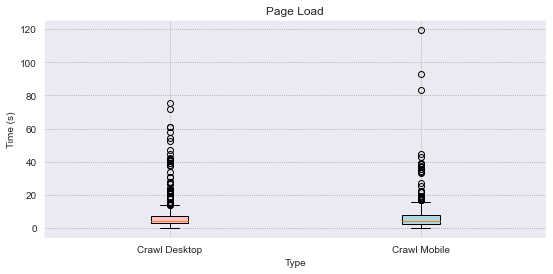

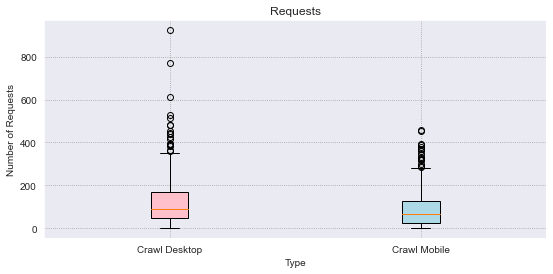

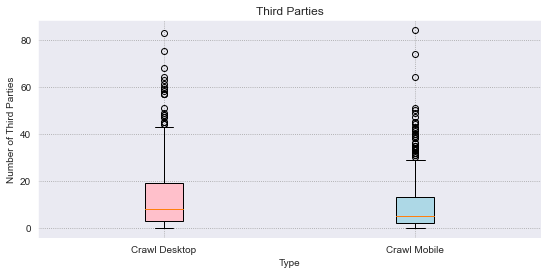

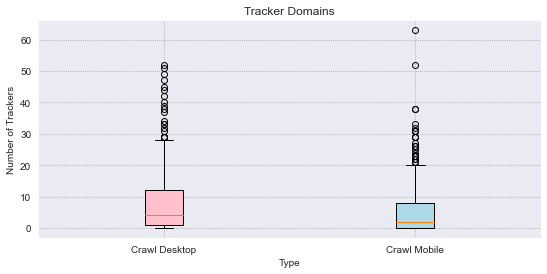

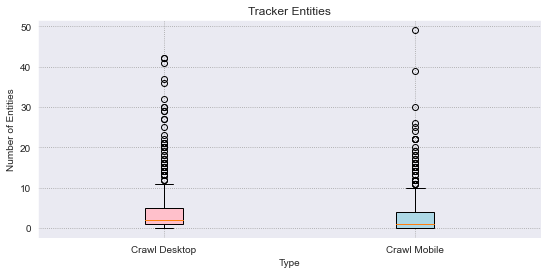

In [199]:

generate_box_plot(page_load_time_desktop,page_load_time_mobile,"Page Load","Time (s)")
generate_box_plot(num_requests_desktop,num_requests_mobile,"Requests","Number of Requests")
generate_box_plot(num_third_parties_desktop,num_third_parties_mobile,"Third Parties","Number of Third Parties")
generate_box_plot(num_trackers_domain_desktop,num_trackers_domain_mobile,"Tracker Domains","Number of Trackers")
generate_box_plot(num_trackers_ent_desktop,num_trackers_ent_mobile,"Tracker Entities","Number of Entities")



In [200]:
page_load_time_desktop=np.array(page_load_time_desktop)
page_load_time_mobile=np.array(page_load_time_mobile)

num_requests_desktop=np.array(num_requests_desktop)
num_requests_mobile=np.array(num_requests_mobile)

num_third_parties_desktop=np.array(num_third_parties_desktop)
num_third_parties_mobile=np.array(num_third_parties_mobile)

num_trackers_domain_desktop=np.array(num_trackers_domain_desktop)
num_trackers_domain_mobile=np.array(num_trackers_domain_mobile)

num_trackers_ent_desktop=np.array(num_trackers_ent_desktop)
num_trackers_ent_mobile=np.array(num_trackers_ent_mobile)

In [201]:
page_load_time_desktop_stats=[np.min(page_load_time_desktop),np.max(page_load_time_desktop),np.median(page_load_time_desktop)]
page_load_time_mobile_stats=[np.min(page_load_time_mobile),np.max(page_load_time_mobile),np.median(page_load_time_mobile)]

num_requests_desktop_stats=[np.min(num_requests_desktop),np.max(num_requests_desktop),np.median(num_requests_desktop)]
num_requests_mobile_stats=[np.min(num_requests_mobile),np.max(num_requests_mobile),np.median(num_requests_mobile)]

num_third_parties_desktop_stats=[np.min(num_third_parties_desktop),np.max(num_third_parties_desktop),np.median(num_third_parties_desktop)]
num_third_parties_mobile_stats=[np.min(num_third_parties_mobile),np.max(num_third_parties_mobile),np.median(num_third_parties_mobile)]

num_trackers_domain_desktop_stats=[np.min(num_trackers_domain_desktop),np.max(num_trackers_domain_desktop),np.median(num_trackers_domain_desktop)]
num_trackers_domain_mobile_stats=[np.min(num_trackers_domain_mobile),np.max(num_trackers_domain_mobile),np.median(num_trackers_domain_mobile)]

num_trackers_ent_desktop_stats=[np.min(num_trackers_ent_desktop),np.max(num_trackers_ent_desktop),np.median(num_trackers_ent_desktop)]
num_trackers_ent_mobile_stats=[np.min(num_trackers_ent_mobile),np.max(num_trackers_ent_mobile),np.median(num_trackers_ent_mobile)]


In [202]:
print("******************* MIN ***** MAX **** MEDIAN *******")
print("page load desktop",page_load_time_desktop_stats)
print("page load mobile",page_load_time_mobile_stats)

print("requests desktop",num_requests_desktop_stats)
print("requests mobile",num_requests_mobile_stats)

print("third parties desktop",num_third_parties_desktop_stats)
print("third parties mobile",num_third_parties_mobile_stats)

print("trackers desktop",num_trackers_domain_desktop_stats)
print("trackers mobile",num_trackers_domain_mobile_stats)

print("Tracker entities",num_trackers_ent_desktop_stats)
print("Tracker entities",num_trackers_ent_mobile_stats)






******************* MIN ***** MAX **** MEDIAN *******
page load desktop [0.05911993980407715, 75.25218749046326, 4.516522645950317]
page load mobile [0.18329477310180664, 119.30273723602295, 4.374066472053528]
requests desktop [1, 924, 90.0]
requests mobile [1, 459, 67.5]
third parties desktop [0, 83, 8.0]
third parties mobile [0, 84, 5.0]
trackers desktop [0, 52, 4.0]
trackers mobile [0, 63, 2.0]
Tracker entities [0, 42, 2.0]
Tracker entities [0, 49, 1.0]


In [203]:
def get_top_elements(domains,num):
    domains_count=dict(Counter(domains))
    domains_sorted = sorted(domains_count, key=domains_count.get, reverse=True)
    i=0
    for e in domains_sorted:
        print(e,domains_count[e])
        i=i+1
        if (i==num):
            return


In [204]:
print("*******************top ten desktop third party domains*************")
get_top_elements(third_parties_desktop_list,10)
print("*******************top ten mobile third party domains**************")
get_top_elements(third_parties_mobile_list,10)

*******************top ten desktop third party domains*************
google.com 218
doubleclick.net 210
google-analytics.com 200
googletagmanager.com 189
google.nl 166
gstatic.com 123
facebook.com 112
facebook.net 100
googleadservices.com 90
fonts.googleapis.com 86
*******************top ten mobile third party domains**************
google.com 169
doubleclick.net 162
google-analytics.com 152
googletagmanager.com 149
google.nl 118
gstatic.com 102
facebook.com 76
googleadservices.com 64
facebook.net 63
fonts.googleapis.com 61


In [205]:
print("*******************top ten desktop trackers*************")
get_top_elements(tracker_domain_desktop_list,10)
print("*******************top ten mobile trackers**************")
get_top_elements(tracker_domain_mobile_list,10)

*******************top ten desktop trackers*************
google.com 218
doubleclick.net 210
google-analytics.com 200
google.nl 166
gstatic.com 123
facebook.com 112
facebook.net 100
googleadservices.com 90
googlesyndication.com 70
twitter.com 63
*******************top ten mobile trackers**************
google.com 169
doubleclick.net 162
google-analytics.com 152
google.nl 118
gstatic.com 102
facebook.com 76
googleadservices.com 64
facebook.net 63
googlesyndication.com 53
adsrvr.org 47


In [206]:
print("*******************top ten desktop  tracker entities*************")
get_top_elements(tracker_ent_desktop_list,10)
print("*******************top ten mobile tracker entities**************")
get_top_elements(tracker_ent_mobile_list,10)

*******************top ten desktop  tracker entities*************
Google LLC 289
Facebook, Inc. 119
Microsoft Corporation 90
Adobe Inc. 75
Amazon Technologies, Inc. 71
Twitter, Inc. 66
comScore, Inc 55
The Trade Desk Inc 55
LiveRamp 46
Oracle Corporation 42
*******************top ten mobile tracker entities**************
Google LLC 233
Facebook, Inc. 80
Microsoft Corporation 67
Amazon Technologies, Inc. 56
Adobe Inc. 51
comScore, Inc 47
The Trade Desk Inc 47
Oracle Corporation 36
Twitter, Inc. 34
LiveRamp 32


In [207]:
def generate_scatter_plot(data_desktop,data_mobile,tranco_desktop,tranco_mobile,x_label,y_label):
    fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(24, 8))
    ax1.set_xlabel(x_label,fontsize=16)
    ax1.set_ylabel(y_label,fontsize=16)
    ax1.set_title("Crawl Desktop",fontsize=22)
    sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
    sns.regplot(x=np.array(tranco_desktop,dtype='int'), y=np.array(data_desktop,dtype='int'), ax=ax1)
    ax2.set_xlabel(x_label,fontsize=16)
    ax2.set_ylabel(y_label,fontsize=16)
    ax2.set_title("Crawl Mobile",fontsize=22)
    sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
    sns.regplot(x=np.array(tranco_mobile,dtype='int'), y=np.array(data_mobile,dtype='int'), ax=ax2)
    plt.savefig(y_label+'.jpg')
    plt.show()

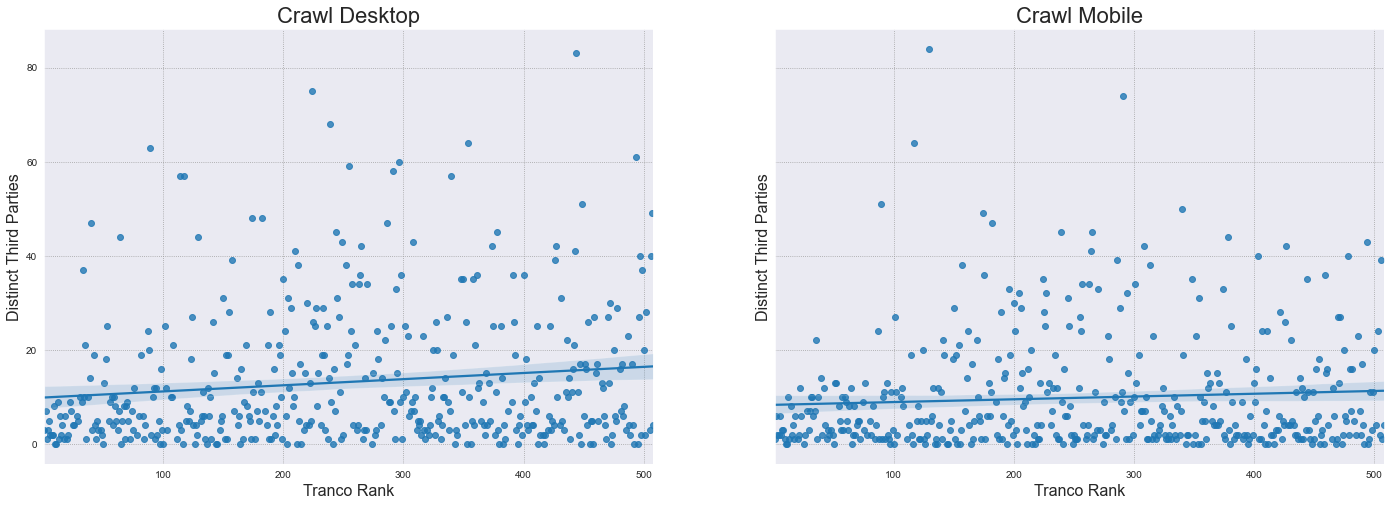

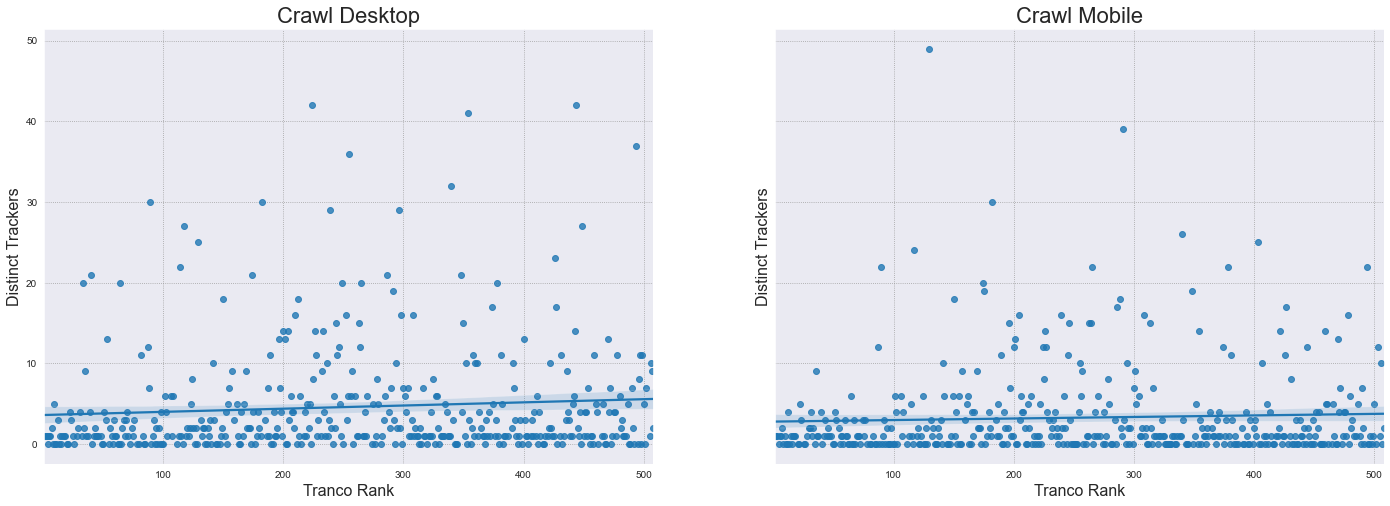

In [208]:
    generate_scatter_plot(num_third_parties_desktop,num_third_parties_mobile,analysis_tranco_desktop,analysis_tranco_mobile,"Tranco Rank","Distinct Third Parties")

    generate_scatter_plot(num_trackers_ent_desktop,num_trackers_ent_mobile,analysis_tranco_desktop,analysis_tranco_mobile,"Tranco Rank","Distinct Trackers")

In [209]:
print("******************MAX COOKIES DESKTOP*****************")

print("Request Hostname:",max_cookie_req_desk)
print("Request Website:",max_cookie_website_desk)
print("Number of Cookies:",max_cookie_num_desk)
print("First Party:",max_first_party_desk)

print("******************MAX COOKIES Mobile*****************")
print("Request Hostname:",max_cookie_req_mob)
print("Request Website:",max_cookie_website_mob)
print("Number of Cookies:",max_cookie_num_mob)
print("First Party:",max_first_party_mob)


******************MAX COOKIES DESKTOP*****************
Request Hostname: ['https://www.telegraph.co.uk/customer/lib/tmguser@v1.0.0/tmguser.js']
Request Website: ['telegraph.co.uk']
Number of Cookies: [42]
First Party: [True]
******************MAX COOKIES Mobile*****************
Request Hostname: ['https://hbr.org/resources/images/marketing/houseads/ad_HBRMustReadsBox_230.png']
Request Website: ['hbr.org']
Number of Cookies: [42]
First Party: [True]


In [210]:
print("******************TOP COOKIES DESKTOP*****************")
print("cookie 1:", top_cookies_desktop[0],'\n',"lifespan:", top_lifespan_desktop[0],'\n')
print("cookie 2:", top_cookies_desktop[1],'\n',"lifespan:", top_lifespan_desktop[1],'\n')
print("cookie 3:", top_cookies_desktop[2],'\n',"lifespan:", top_lifespan_desktop[2],'\n')
print("******************TOP COOKIES MOBILE*****************")
print("cookie 1:", top_cookies_mobile[0],'\n',"lifespan:", top_lifespan_mobile[0],'\n')
print("cookie 2:", top_cookies_mobile[1],'\n',"lifespan:", top_lifespan_mobile[1],'\n')
print("cookie 1:", top_cookies_mobile[2],'\n',"lifespan:", top_lifespan_mobile[2],'\n')



******************TOP COOKIES DESKTOP*****************
cookie 1: uid=f8a821eee8f74f34bb6a520eaa906271;domain=.xinhuanet.com;expires=Wednesday, 02-Nov-2099 00:00:00 GMT;path=/; 
 lifespan: 28272 days, 8:07:56.084070 

cookie 2: uid=73820b15955c497bb8126903ca0fa4f1;domain=.xinhuanet.com;expires=Wednesday, 02-Nov-2099 00:00:00 GMT;path=/; 
 lifespan: 28272 days, 8:07:56.084007 

cookie 3: uid=29742aea49214590a2e0f9ebf54f76a4;domain=.xinhuanet.com;expires=Wednesday, 02-Nov-2099 00:00:00 GMT;path=/; 
 lifespan: 28272 days, 8:07:56.083961 

******************TOP COOKIES MOBILE*****************
cookie 1: uid=41dc0f4c80fa48d7a605fb127e754082;domain=.xinhuanet.com;expires=Wednesday, 02-Nov-2099 00:00:00 GMT;path=/; 
 lifespan: 28272 days, 8:07:50.542904 

cookie 2: uid=79220a14b97142afa213563a7bcbbafc;domain=.xinhuanet.com;expires=Wednesday, 02-Nov-2099 00:00:00 GMT;path=/; 
 lifespan: 28272 days, 8:07:50.542845 

cookie 1: uid=73820b15955c497bb8126903ca0fa4f1;domain=.xinhuanet.com;expires=Wedn

In [211]:
print("******************RIDIRECT PAIRS DESKTOP*****************")

print(Counter(chain(redirect_desktop)))
print("******************RIDIRECT PAIRS MOBILE*****************")

print(Counter(chain(redirect_mobile)))


******************RIDIRECT PAIRS DESKTOP*****************
Counter({('doubleclick.net', 'google.com'): 104, ('google.com', 'google.nl'): 95, ('doubleclick.net', 'everesttech.net'): 60, ('google.com', 'doubleclick.net'): 41, ('doubleclick.net', 'pubmatic.com'): 30, ('clarity.ms', 'bing.com'): 29, ('bing.com', 'clarity.ms'): 28, ('mathtag.com', 'pubmatic.com'): 21, ('loopme.me', 'lkqd.net'): 14, ('turn.com', 'lkqd.net'): 14, ('doubleclick.net', 'demdex.net'): 13, ('youtube.com', 'google.com'): 13, ('google.nl', 'doubleclick.net'): 12, ('de17a.com', 'pubmatic.com'): 11, ('quantserve.com', 'pubmatic.com'): 10, ('pubmatic.com', 'doubleclick.net'): 9, ('adform.net', 'pubmatic.com'): 9, ('rlcdn.com', 'demdex.net'): 9, ('unrulymedia.com', '1rx.io'): 9, ('yahoo.com', 'rubiconproject.com'): 7, ('fiftyt.com', 'pubmatic.com'): 7, ('yahoo.com', 'pubmatic.com'): 7, ('bidr.io', 'company-target.com'): 6, ('adsrvr.org', 'rubiconproject.com'): 6, ('onaudience.com', 'crwdcntrl.net'): 6, ('crwdcntrl.net', 

In [212]:
print(domain_not_found)

['https://118.89.204.198/resolv?host=www.zhihu.com&os_type=web', 'https://103.44.59.54/3ea', 'https://118.26.32.19/3f0/hd.cloud.iqiyi.com/d?dn=cache.video.iqiyi.com&business=pcwPlayer&cross-domain=1', 'https://103.44.59.54/3ea', 'https://118.26.32.19/3f0/hd.cloud.iqiyi.com/d?dn=cache.video.iqiyi.com&business=pcwPlayer&cross-domain=1', 'https://118.89.204.198/resolv?host=www.zhihu.com&os_type=web']


In [213]:
print(unhandled_time_formats)

['Monday, 06-Jun-2022 19:15:11 CST', 'Thursday, 03-Jun-2032 19:14:11 CST', 'Monday, 06-Jun-2022 19:15:11 CST']


In [214]:
print (not_valid_domain)

[]
